# Gambler's Problem
Shantanu Laghate, November 2024

## Problem Statement
A gambler has the opportunity to make bets on the outcomes of a sequence of coin flips, with $p_h$ probability of flipping heads independently. 
- If the coin is heads, he wins as many dollars as he staked on that flip. If it's tails, he loses his stake. 
- The game ends when the gambler wins by reaching his goal of $100, or loses by running out of money. 
- On each flip, the gabler must decide what portion of his capital to take, in integer number of dollars.

## Formulation to MDP:
- Undiscounted, episodic, finite MDP.
- State: gambler's capital, $s \in \{1, 2, ..., 99\}$
- Actions: stakes, $a \in \{0, 1, ..., min(s, 100-s)\}$
- Rewards: 0 on all transitions except when gambler reaches his goal of $100.
- The state-value function given the probability of winning from each state.
- A policy is a mapping from levels of capital to stakes. The optimal policy maximizes the probability of winning from each state. 

## Solution via Value Iteration
Value iteration is an instance of Generalized Policy Iteration (GPI). Until convergence of the optimal policy, you sweep the state space making updates according to the Bellman Optimality Equation:

$$ v_{k+1}(s) = \max_a \sum_{s',r} p(s', r | s, a) [r + \gamma v_k(s')] $$

In this problem's case, the sum simplifies based on how much is at stake. There are only 2 possible ${s', r}$ pairs, one for the case that the coin flips Heads, the other Tails. The action space is defined such that the agent cannot stake more than the capital available, or more than what would make the total on a heads flip equal 100. Note that the reward for any tails coin flip is always 0. The reward for a heads coin flip is 1 only in the case when $s+a = 100$

Note that for an episodic task, the discount factor $\gamma = 0$. As we increase the goal beyond 100, loops can be more easily introduced in the iteration and the discount factor helps avoid them. 

$$ v_{k+1}(s) = \max_a p_h[\mathbb{1}_{s+a=100} + \gamma v_k(s+a)] + (1-p_h)\gamma v_k(s-a) $$

After the value function has converged, we can determine a policy $\pi \approx \pi_*$ such that:

$$ \pi(s) = \underset{a}{\operatorname{argmax}} p_h[\mathbb{1}_{s+a=100} + \gamma v(s+a)] + (1-p_h)\gamma v(s-a)$$

The value iteration algorithm is given below in pseudocode. Note that the policy computation only happens after the value function has approximately converged, but we can think of the value function update using Bellman's Optimality Equation as doing one round of greedy action selection while doing the value update:
```
Value Iteration:
    initialize V(s) = 0 for all s in S
    
    while True:
        delta = 0
        for s in S:
            v = V(s)
            V(s) = updated as above
            delta = max(delta, |v-V(s|)
        if delta < threshold:
            break
    
    Compute a policy according to the greedy function above. 
```

## Outputs
- Observe value function convergence after successive state sweeps of Value Iteration.
- Shape of optimal policy, and why it looks a certain way
- Value functions and optimal policies for different values of $p_h$

## Notes
* Selecting the optimal policy function:
    + floating-point error can mess up your `argmax`. To avoid floating point errors, do a fuzzy comparison between value estimates by re-using the same threshold for value convergence and finding all values that are within that threshold to be considered equal.
    + Tendency to pick action 0 - for values of $p_h < 0.5$, doing nothing is considered one of the "optimal" actions because the coin is biased against you and you'll lose more often than you win. So if you have some capital you might as well keep it. Since this is not interesting, I forced the agent to pick a non-zero action in these cases.
    + There are multiple optimal policies. All of them have a sawtooth/triangle shape. The way to visualize them is by choosing different tie-breaking strategies.
* When $p_h > 0.5$, the shape of the value function changes drastically. It favors the optimal policy essentially just betting 1 every time.
    + At exactly $p_h=0.5$, bet sizing doesn't matter. All bets are made equal.
    + At $p_h<0.5$, you get spikes of the value function at spots where you can quickly win, so the optimal policy is essentially trying to get you to those spikes. Optimal policies are the same for all $p_h < 0.5$. 

In [138]:
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
import logging

logging.basicConfig(
    level=logging.DEBUG,  # Set default logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

In [142]:
type Policy = np.Array
PH = 0.4
GOAL = 100
GAMMA = 1
THRESHOLD = 1e-8

def get_expectation(state, action, values, ph = PH, goal = GOAL, gamma = GAMMA):
    heads_state = state+action
    tails_state = state-action
    heads_reward = (heads_state == GOAL)
    # you never get any reward on tails, but 0 is terminal state
    tails_reward = 0
    expectation = ph*(heads_reward + GAMMA*values[heads_state]) + (1-ph)*(tails_reward + GAMMA*values[tails_state])

    return expectation


def value_iteration(ph: float = PH, threshold: float = THRESHOLD, goal: int = GOAL, gamma: float = GAMMA):
    value_function_iterations = []
    V = np.zeros(GOAL+1)
    V[GOAL] = 0

    iteration = 0

    # Value Function Convergence
    while True:
        delta = 0
        for s in range(GOAL+1):
            # terminal states do not get updated. 
            if (s == 0 or s == GOAL):
                continue
            # actions = {0, 1, .., min(GOAL-s, s)}
            actions = np.arange(min(GOAL-s, s)+1)
            action_expectations = [get_expectation(s, action, V, ph, goal, gamma) for action in actions]
            
            old_value = V[s]
            V[s] = max(action_expectations)
            delta = max(delta, abs(old_value-V[s]))
        
        
        iteration += 1
        save_copy = V.copy()
        save_copy[GOAL] = 1
        value_function_iterations.append(save_copy)
        
        
        if delta < THRESHOLD:
            logger.debug(f"Converged after {iteration} iterations")
            break

    # Optimal Deterministic Policy
    pi = np.zeros(GOAL+1)
    for s in range(GOAL+1):
        if s == 0 or s == GOAL:
            continue

        actions = np.arange(min(GOAL-s, s)+1)
        action_expectations = np.array([get_expectation(s, action, V, ph, goal, gamma) for action in actions])

        # pick highest action with the same expectation
        max_value = np.max(action_expectations)
        highest_index = np.where(np.abs(action_expectations - max_value) < THRESHOLD)[0]
        logger.debug(f"equal actions in state {s}: {highest_index}")

        # invalidate the 0 action
        if highest_index[0] == 0:
            highest_index = highest_index[1:]

        pi[s] = highest_index[0]
        
    # to make graph prettier
    V[GOAL] = 1        
    return pi, V, value_function_iterations

In [143]:
def create_plots(policy, value_function_iterations, ph):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the optimal policy
    ax1.plot(rows, policy, 'o-', markersize=2, color='b')
    ax1.set_xlabel("State (capital available)")
    ax1.set_ylabel("Optimal Bet Size")
    ax1.set_title(f"Optimal Policy Stake Amount in each State \n with $p_h=${ph}")
    ax1.grid(True)

    # plot the value function iterations
    # Get a color map with a distinct color for each line
    colors = cm.Reds(np.linspace(0.5, 1, len(value_function_iterations)))
    
    # Plot each array with a unique color
    for idx, (array, color) in enumerate(zip(value_function_iterations, colors)):
        ax2.plot(array, label=f"Iteration {idx+1}", color=color, linewidth=1)
        

    ax2.set_xlabel("State")
    ax2.set_ylabel("Value")
    ax2.set_title(f"Value Functions Convergence with $p_h=${ph} \n using Value Iteration")
    ax2.grid(True)

    return fig

# Optimal Policy and Value Function for $p_h = 0.4$

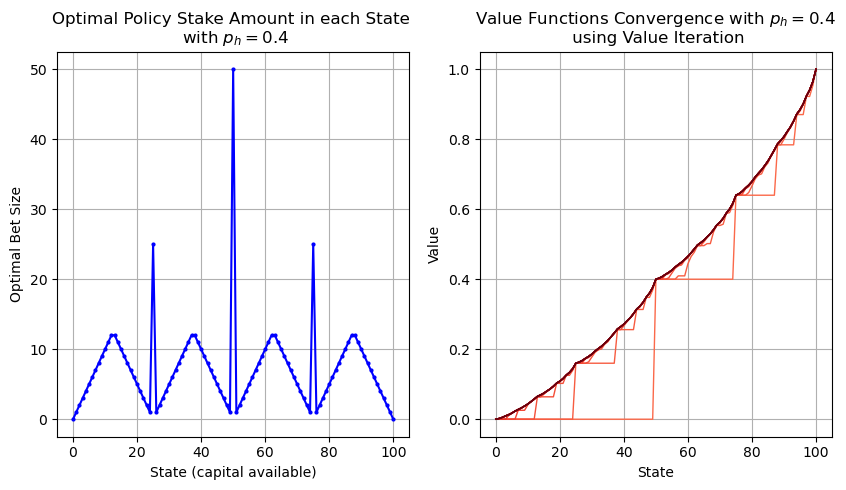

In [170]:
# set to DEBUG to see all equally valued actions
logger.setLevel("INFO")
policy, values, value_function_iterations = value_iteration(ph=0.4)

fig = create_plots(policy, value_function_iterations, 0.4)
plt.savefig("ph0.4.png")

# Optimal Policy and Value Functions for $p_h=0.25$

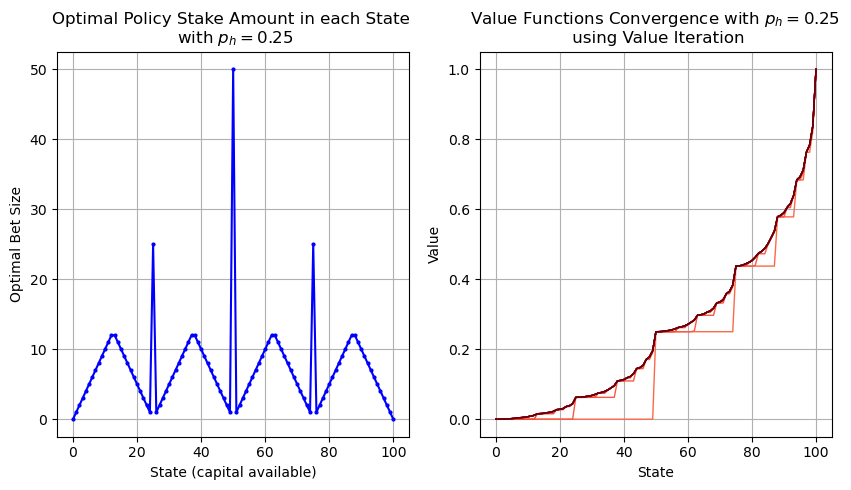

In [171]:
# set to DEBUG to see all equally valued actions
logger.setLevel("INFO")
policy, values, value_function_iterations = value_iteration(ph=0.25)

fig = create_plots(policy, value_function_iterations, 0.25)
plt.savefig("ph0.25.png")

# Optimal Policy and Value Functions for $p_h = 0.55$

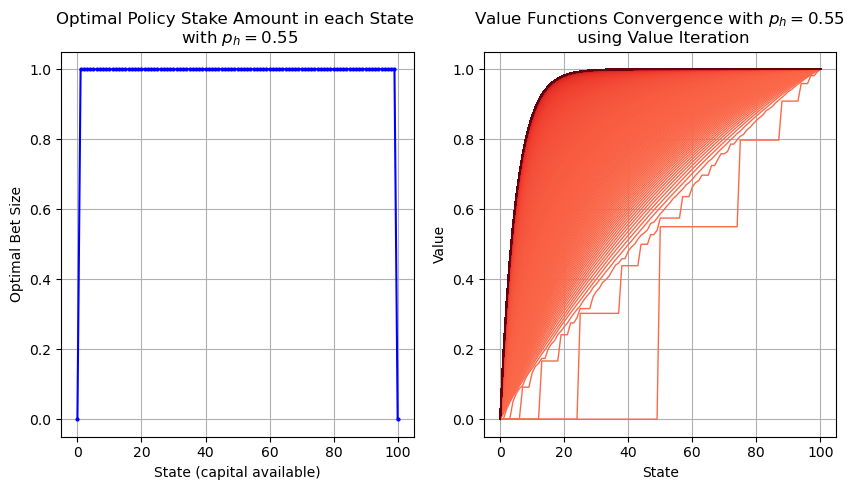

In [172]:
# set to DEBUG to see all equally valued actions
logger.setLevel("INFO")
policy, values, value_function_iterations = value_iteration(ph=0.55)

fig = create_plots(policy, value_function_iterations, 0.55)
plt.savefig("ph0.55.png")

# Optimal Policy and Value Functions for $p_h = 0.5$

2024-11-10 17:22:04,819 - __main__ - DEBUG - Converged after 11 iterations
2024-11-10 17:22:04,820 - __main__ - DEBUG - equal actions in state 1: [0 1]
2024-11-10 17:22:04,820 - __main__ - DEBUG - equal actions in state 2: [0 1 2]
2024-11-10 17:22:04,821 - __main__ - DEBUG - equal actions in state 3: [0 1 2 3]
2024-11-10 17:22:04,821 - __main__ - DEBUG - equal actions in state 4: [0 1 2 3 4]
2024-11-10 17:22:04,822 - __main__ - DEBUG - equal actions in state 5: [0 1 2 3 4 5]
2024-11-10 17:22:04,823 - __main__ - DEBUG - equal actions in state 6: [0 1 2 3 4 5 6]
2024-11-10 17:22:04,823 - __main__ - DEBUG - equal actions in state 7: [0 1 2 3 4 5 6 7]
2024-11-10 17:22:04,823 - __main__ - DEBUG - equal actions in state 8: [0 1 2 3 4 5 6 7 8]
2024-11-10 17:22:04,824 - __main__ - DEBUG - equal actions in state 9: [0 1 2 3 4 5 6 7 8 9]
2024-11-10 17:22:04,824 - __main__ - DEBUG - equal actions in state 10: [ 0  1  2  3  4  5  6  7  8  9 10]
2024-11-10 17:22:04,825 - __main__ - DEBUG - equal ac

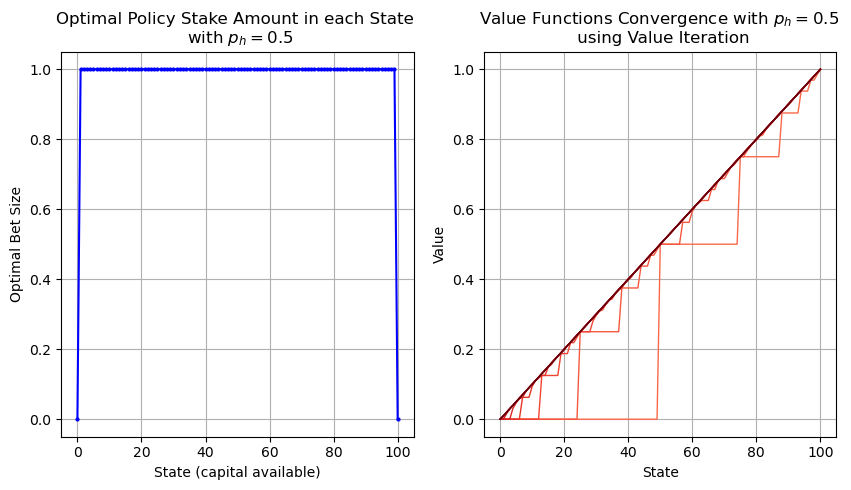

In [173]:
# set to DEBUG to see all equally valued actions
logger.setLevel("DEBUG")
policy, values, value_function_iterations = value_iteration(ph=0.5)

fig = create_plots(policy, value_function_iterations, 0.5)
plt.savefig("ph0.5.png")

# Comparing Shapes of Value Functions By Varying $p_h$

In [175]:
# set to DEBUG to see all equally valued actions
logger.setLevel("INFO")

phs = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
values = []
policies = []

for ph in phs:
    policy, value, value_function_iterations = value_iteration(ph)
    values.append(value)
    policies.append(policy)


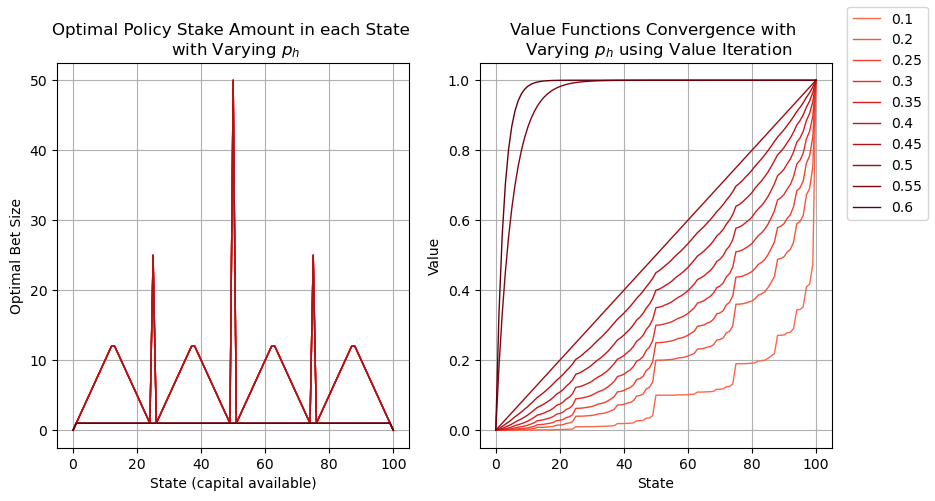

In [177]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
colors = cm.Reds(np.linspace(0.5, 1, len(values)))

# Plot each array with a unique color
for idx, (array, color) in enumerate(zip(policies, colors)):
    ax1.plot(array, label=f"{phs[idx]}", color=color, linewidth=1)

ax1.set_xlabel("State (capital available)")
ax1.set_ylabel("Optimal Bet Size")
ax1.set_title(f"Optimal Policy Stake Amount in each State \n with Varying $p_h$")
ax1.grid(True)

# Plot each array with a unique color
for idx, (array, color) in enumerate(zip(values, colors)):
    ax2.plot(array, label=f"{phs[idx]}", color=color, linewidth=1)
    

ax2.set_xlabel("State")
ax2.set_ylabel("Value")
ax2.set_title(f"Value Functions Convergence with \n Varying $p_h$ using Value Iteration")
ax2.grid(True)

# Gather handles and labels from each subplot
handles, labels = [], []
for ax in [ax1, ax2]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:  # Avoid duplicates
            handles.append(handle)
            labels.append(label)

# Create a single legend on the figure level
fig.legend(handles, labels)
fig.savefig("parameter-study.png")
